# Data cleaning

Preprocess missing values (N/A)

In [98]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [99]:
def load_by_chunks(path: str, chunk_size: int = 50_000) -> pd.DataFrame:
    chunks = pd.read_csv(path, chunksize=chunk_size)
    return pd.concat(chunks, ignore_index=True)

X_test = load_by_chunks('X_test_Hi5.csv')

<ipython-input-99-64d3abcb1af2>:5: DtypeWarning: Columns (1,5) have mixed types.Specify dtype option on import or set low_memory=False.
  X_test = load_by_chunks('X_test_Hi5.csv')
<ipython-input-99-64d3abcb1af2>:5: DtypeWarning: Columns (130,133,134) have mixed types.Specify dtype option on import or set low_memory=False.
  X_test = load_by_chunks('X_test_Hi5.csv')
<ipython-input-99-64d3abcb1af2>:5: DtypeWarning: Columns (108,110,111,115,117,118,122,124,125,130,133,134) have mixed types.Specify dtype option on import or set low_memory=False.
  X_test = load_by_chunks('X_test_Hi5.csv')
<ipython-input-99-64d3abcb1af2>:5: DtypeWarning: Columns (1,5,130,133,134) have mixed types.Specify dtype option on import or set low_memory=False.
  X_test = load_by_chunks('X_test_Hi5.csv')


## Remove columns with too many missing values

In [100]:
def rows_with_missing_values(df: pd.DataFrame) -> pd.Series:
    """
    Returns the columns left with missing values to handle individually,
    by replacing with means or something else.
    """
    missing_values = df.isna().sum()
    return missing_values[missing_values > 0] / len(df)

In [101]:
rows_with_missing_values(X_test)

piezo_station_investigation_depth       0.063568
piezo_station_pe_label                  0.079281
piezo_station_bdlisa_codes              0.048592
piezo_producer_code                     0.032586
piezo_producer_name                     0.032586
piezo_measure_nature_code               0.032997
piezo_measure_nature_name               0.032997
meteo_rain_height                       0.011538
meteo_DRR                               0.885874
meteo_temperature_min                   0.031750
meteo_time_tn                           0.045138
meteo_temperature_max                   0.031772
meteo_time_tx                           0.044893
meteo_temperature_avg                   0.041766
meteo_temperature_avg_threshold         0.031816
meteo_temperature_min_ground            0.734729
meteo_temperature_min_50cm              0.842638
meteo_frost_duration                    0.089945
meteo_amplitude_tn_tx                   0.031816
meteo_temperature_avg_tntm              0.031816
meteo_pressure_avg  

In [102]:
def columns_to_drop(df: pd.DataFrame, threshold=0.2):
    to_drop = df.isna().sum() / len(df) > threshold
    return [col for col in df.columns if to_drop[col]]

In [103]:
def drop_columns(df: pd.DataFrame, threshold=0.2, inplace=False):
    """
    Drop columns with a fraction of more than `threshold` missing values.
    """
    threshold = int((1.0 - threshold) * len(df))
    return df.dropna(axis=1, thresh=threshold, inplace=inplace)

In [104]:
drop_columns(X_test, inplace=True)
rows_with_missing_values(X_test)

piezo_station_investigation_depth    0.063568
piezo_station_pe_label               0.079281
piezo_station_bdlisa_codes           0.048592
piezo_producer_code                  0.032586
piezo_producer_name                  0.032586
piezo_measure_nature_code            0.032997
piezo_measure_nature_name            0.032997
meteo_rain_height                    0.011538
meteo_temperature_min                0.031750
meteo_time_tn                        0.045138
meteo_temperature_max                0.031772
meteo_time_tx                        0.044893
meteo_temperature_avg                0.041766
meteo_temperature_avg_threshold      0.031816
meteo_frost_duration                 0.089945
meteo_amplitude_tn_tx                0.031816
meteo_temperature_avg_tntm           0.031816
meteo_evapotranspiration_grid        0.045606
insee_%_agri                         0.009313
insee_pop_commune                    0.009313
insee_med_living_level               0.009313
insee_%_ind                       

In [105]:
def preprocess_prelevement(df: pd.DataFrame):
    """
    For prelevement data, only keep the max of the 0, 1 and 2 prelevement data
    by modifying the dataframe in-place.
    """
    # Define prelevement-related columns
    prelev_columns = {
        "structure": ["prelev_structure_code_0", "prelev_structure_code_1", "prelev_structure_code_2"],
        "volume": ["prelev_volume_0", "prelev_volume_1", "prelev_volume_2"],
        "usage_label": ["prelev_usage_label_0", "prelev_usage_label_1", "prelev_usage_label_2"],
        "volume_mode": ["prelev_volume_obtention_mode_label_0", "prelev_volume_obtention_mode_label_1", "prelev_volume_obtention_mode_label_2"],
        "longitude": ["prelev_longitude_0", "prelev_longitude_1", "prelev_longitude_2"],
        "latitude": ["prelev_latitude_0", "prelev_latitude_1", "prelev_latitude_2"],
        "commune_code": ["prelev_commune_code_insee_0", "prelev_commune_code_insee_1", "prelev_commune_code_insee_2"]
    }

    # Step 1: Get the index of the maximum volume for each row
    try:
        max_volume_index = df[prelev_columns["volume"]].values.argmax(axis=1)
    except KeyError:
        pass # all three columns have been dropped already
    # Step 2: For each column group, select the corresponding value based on max_volume_index
    for key, cols in prelev_columns.items():
        try:
            # Convert columns to a NumPy array
            data_array = df[cols].values

            # Use advanced indexing to select the appropriate value for each row
            df[f"{key}_max"] = data_array[np.arange(len(df)), max_volume_index]
        except KeyError:
            pass # all three columns have been dropped already

    # Step 3: Drop the old columns
    columns_to_drop = [col for cols in prelev_columns.values() for col in cols if col in df.columns]
    df.drop(columns=columns_to_drop, inplace=True)

In [106]:
preprocess_prelevement(X_test)

## Remove rows with too many missing values

In [107]:
def drop_rows(df: pd.DataFrame, threshold=5, inplace=False):
    """
    Drop rows with more than `threshold` missing values.
    """
    threshold = len(df.columns) - threshold
    return df.dropna(axis=0, thresh=threshold, inplace=inplace)

In [108]:
drop_rows(X_test, inplace=True)
X_test.head(200)

,row_index,piezo_station_department_code,piezo_station_update_date,piezo_station_investigation_depth,piezo_station_department_name,piezo_station_commune_code_insee,piezo_station_pe_label,piezo_station_bdlisa_codes,piezo_station_altitude,piezo_station_bss_code,piezo_station_commune_name,piezo_station_longitude,piezo_station_latitude,piezo_station_bss_id,piezo_bss_code,piezo_measurement_date,piezo_obtention_mode,piezo_status,piezo_qualification,piezo_continuity_code,piezo_continuity_name,piezo_producer_code,piezo_producer_name,piezo_measure_nature_code,piezo_measure_nature_name,meteo_id,meteo_name,meteo_latitude,meteo_longitude,meteo_altitude,meteo_date,meteo_rain_height,meteo_temperature_min,meteo_time_tn,meteo_temperature_max,meteo_time_tx,meteo_temperature_avg,meteo_temperature_avg_threshold,meteo_frost_duration,meteo_amplitude_tn_tx,meteo_temperature_avg_tntm,meteo_evapotranspiration_grid,distance_piezo_meteo,hydro_station_code,hydro_observation_date_elab,hydro_observation_result_elab,hydro_status_code,hydro_status_label,hydro_method_code,hydro_method_label,hydro_qualification_code,hydro_qualification_label,hydro_longitude,hydro_latitude,hydro_hydro_quantity_elab,distance_piezo_hydro,insee_%_agri,insee_pop_commune,insee_med_living_level,insee_%_ind,insee_%_const
0,2331795,01,Sun Jul 14 13:00:02 CEST 2024,20.00,Ain,01073,PIEZOMETRE - MARAIS DE LAVOURS (CEYZERIEU - BR...,['712AH37'],232.00,07004X0046/D6-20,Ceyzérieu,5.748241,45.828148,BSS001TTQQ,07004X0046/D6-20,2022-06-01,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,Point lié au point précédent,1.960000e+02,Service Géologique Régional Rhône-Alpes (196),N,Naturel,1034004,BELLEY,5.688000,45.769333,330,2022-06-01,7.4,12.8,335.0,23.2,1556.0,17.1,18.00,0.0,10.4,18.0,2.7,8.036207,V142501001,2022-06-01,191.0,16,Donnée validée,12,Interpolation,16,Non qualifiée,5.685831,45.874843,QmM,7.093852,11.8,992.0,25250,2.9,16.2
1,2331796,01,Sun Jul 14 13:00:02 CEST 2024,35.60,Ain,01363,PIEZOMETRE - GRAVIERE (ST-JEAN-LE-VIEUX - BRGM...,['712GB05'],247.25,06754X0077/F1,Saint-Jean-le-Vieux,5.356637,46.028102,BSS001SCTM,06754X0077/F1,2022-06-01,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,Point lié au point précédent,1.960000e+02,Service Géologique Régional Rhône-Alpes (196),N,Naturel,1089001,AMBERIEU,5.329333,45.976500,250,2022-06-01,3.4,10.5,429.0,23.1,1716.0,16.8,16.80,0.0,12.6,16.8,2.5,6.113148,V271201001,2022-06-01,13346.0,16,Donnée validée,12,Interpolation,20,Bonne,5.336428,46.047082,QmJ,2.624373,0.6,1786.0,24660,44.5,11
2,2331797,01,Sun Jul 14 13:00:02 CEST 2024,35.22,Ain,01244,PIEZOMETRE - BORD AUTOROUTE (MEXIMIEUX - BRGM ...,['040AJ43'],218.77,06993X0226/MEXI_2,Meximieux,5.220795,45.895734,BSS001TRPH,06993X0226/MEXI_2,2022-06-01,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,Point lié au point précédent,1.960000e+02,Service Géologique Régional Rhône-Alpes (196),N,Naturel,1027003,BALAN_AERO,5.106667,45.833000,196,2022-06-01,NaN,12.1,357.0,24.9,1506.0,18.0,18.50,0.0,12.8,18.5,2.8,11.258567,V294201001,2022-06-01,16168.0,16,Donnée validée,12,Interpolation,20,Bonne,5.233492,45.906423,QmJ,1.542071,0,8085.0,24890,8.4,7.8
3,2331798,01,Sun Jul 14 13:00:02 CEST 2024,34.20,Ain,01288,PIEZOMETRE - GRENY (PERON - BRGM 01) - BSH,"['516AA00', '516AF00']",499.85,06533X0070/F2,Péron,5.948977,46.201180,BSS001RGXM,06533X0070/F2,2022-06-01,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,Point lié au point précédent,1.960000e+02,Service Géologique Régional Rhône-Alpes (196),N,Naturel,39413001,LA PESSE,5.843000,46.302833,1133,2022-06-01,12.8,5.8,311.0,17.1,1625.0,11.9,11.45,0.0,11.3,11.5,1.5,13.934290,V100001002,2022-06-01,333590.0,16,Donnée validée,12,Interpolation,20,Bonne,5.964334,46.137641,QmM,7.163470,1.5,2838.0,39700,2.4,5.2
4,2331799,01,Sun Jul 14 13:00:02 CEST 2024,37.30,Ain,01422,FORAGE - ENCLOS (TOSSIAT - BRGM 01) - BSH,['507AB00'],260.00,06518X0026/P2,Tossiat,5.313353,46.136402,BSS001RFRV,06518X0026/P2,2022-06-01,Valeur mesurée,Donnée contrôlée niveau 2,Correcte,2.0,Poin

## Visualize missing values

We plot a matrix of N/A values in the tabular dataset.

In [109]:
def plot_missing_values(df: pd.DataFrame):
    # Binary matrix (1 if NaN, 0 otherwise)
    nan_matrix2 = df.isna()
    plt.figure(figsize=(10, 8))  # Adjust figure size according to the dataset
    plt.imshow(nan_matrix2, cmap='Greys', aspect='auto')  # Black = NaN
    plt.colorbar(label='Presence of NaNs (1 = NaN, 0 = Non)')
    plt.title('Map of missing values (NaN)')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.show()

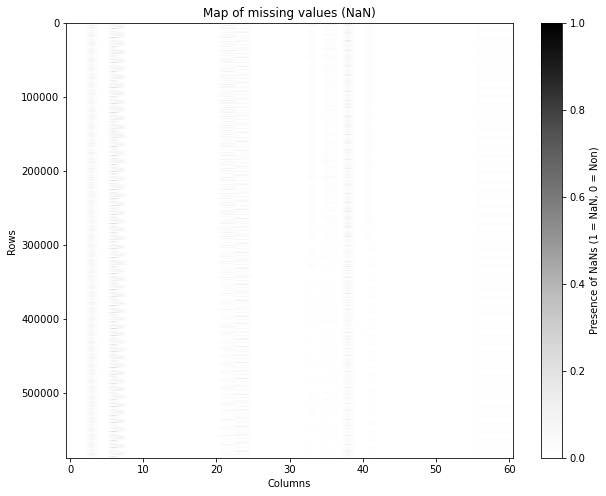

In [110]:
plot_missing_values(X_test)

In [111]:
print(rows_with_missing_values(X_test))

piezo_station_investigation_depth    0.059437
piezo_station_pe_label               0.075308
piezo_station_bdlisa_codes           0.046458
piezo_producer_code                  0.027874
piezo_producer_name                  0.027874
piezo_measure_nature_code            0.026370
piezo_measure_nature_name            0.026370
meteo_rain_height                    0.001673
meteo_time_tn                        0.010257
meteo_time_tx                        0.010005
meteo_temperature_avg                0.006792
meteo_frost_duration                 0.053989
meteo_evapotranspiration_grid        0.012220
insee_%_agri                         0.008254
insee_pop_commune                    0.008254
insee_med_living_level               0.008254
insee_%_ind                          0.008254
insee_%_const                        0.008254
dtype: float64


In [112]:
def fill_nan_with_monthly_department_avg(df, columns_to_fill):
    """
    Fills NaN values in specified columns with the average of other stations
    in the same month and department.
    
    Parameters:
    - df: pandas DataFrame
    - columns_to_fill: list of column names to fill missing values
    
    Returns:
    - DataFrame with NaN values filled
    """
    # Ensure the date column is in datetime format
    df['piezo_measurement_date'] = pd.to_datetime(df['piezo_measurement_date'])
    
    # Extract 'month' from the date if not already present
    if 'month' not in df.columns:
        df['month'] = df['piezo_measurement_date'].dt.month

    # Group by department and month
    grouped = df.groupby(['piezo_station_department_code', 'month'])

    # Iterate over the specified columns to fill
    for col in columns_to_fill:
        # Compute monthly department averages
        avg_values = grouped[col].transform(lambda x: x.mean(skipna=True))
        
        # Fill NaN values with the computed averages
        df[col] = df[col].fillna(avg_values)

    return df

# Usage Example
columns_to_fill = ['piezo_station_investigation_depth', 'piezo_producer_code', 'meteo_rain_height', 'meteo_time_tn', 'meteo_temperature_max', 'meteo_time_tx', 'meteo_temperature_avg', 'meteo_temperature_avg_threshold', 'meteo_frost_duration', 'meteo_amplitude_tn_tx', 'meteo_temperature_avg_tntm', 'meteo_evapotranspiration_grid', 'insee_pop_commune']
X_test = fill_nan_with_monthly_department_avg(X_test, columns_to_fill)

In [113]:
columns_object_to_fill = ['piezo_station_pe_label', 'piezo_station_bdlisa_codes', 'piezo_producer_name', 'piezo_measure_nature_code', 'piezo_measure_nature_name', 'insee_%_agri', 'insee_med_living_level', 'insee_%_ind', 'insee_%_const']

def fill_nan_object_with_most_frequent(df, columns_to_fill):
    for var in columns_to_fill:
        most_frequent_value = df[var].mode()[0]
        df[var].fillna(most_frequent_value, inplace=True)
    return df
        
X_test = fill_nan_object_with_most_frequent(X_test, columns_object_to_fill)

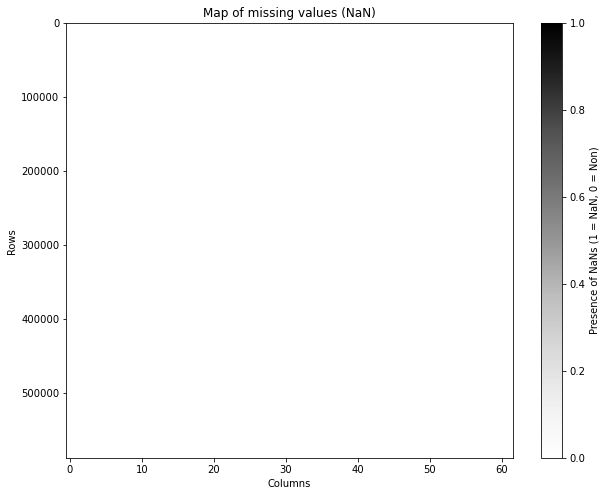

In [114]:
plot_missing_values(X_test)